# Задание 8

## 1. Wiki philosophy (0.5 баллов)
Существует шуточный «закон Философии» для статей Википедии: если переходить по
первой нормальной ссылке в статье, то рано или поздно мы придем на статью о философии.
Ваша задача заключается в том, чтобы проверить этот закон.
Для этого нужно написать программу, которая получает на вход ссылку на статью Википедии, а потом циклически переходит по первой нормальной ссылке и повторяет эту операцию
(до тех пор, пока не будет достигнута статья о философии, или ссылки не зациклятся). Нормальной ссылкой будем называть ссылку, которая находится в основном содержании статьи,
не в инфобоксах и не в служебных блоках, написана синим цветом (красный соответствует
несуществующей статье), не курсивом, не являтся сноской и не находится в скобках.

<b>Результат</b> должен представлять из себя несколько статистик (проверьте не менее 100 стр., <i>больше - лучше</i>):
* Описание алгоритма, как вы решали, стр. по философии или нет?
* Количество начальных ссылок vs Количество конечных тем страниц (0 - стр. не по философии, 1 - по философии).
* Гистограмма длин путей.
* Соотношений успешных и неуспешных запросов.
* Что еще можно тут придумать? :)

<b>Обратите внимание</b>, что для проверки нормальности не обязательно разбирать таблицы стилей и
проверять цвет и т.п., достаточно сделать, чтобы программа работала для текущей верстки
википедии (например, можно использовать атрибут class у тегов).
Для удобства проверки сделайте, чтобы последовательность переходов выводилась на
экран.

<b>Внимание.</b> Чтобы не создавать большую нагрузку на сервер Википедии, сделайте так,
чтобы ваша программа делала не более 2-х запросов в секунду. Для этого воспользуйтесь
функцией sleep из модуля time.

<b>PS</b> Лучше выполнять не в ipython notebook, а прислать отчет в pdf и код.

In [496]:
import time
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Function $findValidLink$ gets soup object and crawles it, looking for the first valid link

In [497]:
titles_links_to_skip=['Особая папка', 
                      'Флаг Германии', 
                      'Григорианский календарь', 
                      'Форма государства',
                      'Логика',
                      'Политика',
                      'Власть (государство)']

def findValidLink(soup):
    page_list = soup.findAll('div', attrs={'class': 'mw-parser-output'})
    if page_list == []:
        return -1
    page = page_list[0]
    parags_p = page.find_all('p')
    link = None
    for parag in parags_p:
        links = parag.find_all('a')
        if len(links) < 2:
            continue
        for l in links[0:]:#changed 1 to 0
            if l != None and l.has_attr('href') and l.has_attr('title'):
                escape = False
                for item in [':', '.', 'язык', 'год', '(страница отсутствует)']:
                    if item in l['title']:
                        escape = True
                        break
                if l['title'] in titles_links_to_skip:
                    escape = True
                if escape:
                    continue
                link = l
                return link
    return -1

Function $crawlWiki$ gets a query and crawles wiki step by step, following the first valid link on each page. When it reaches previously seen page, it prints 'CYCLE' and stops crawling. If the first link is dead or each paragraph $<p>$ on the page doesn't contain link or any other problem, it prints 'STOP' and finishes crawling process.

In [498]:
MAX_CRAWL_DEPTH = 500
def crawlWiki(query):
    template = 'https://ru.wikipedia.org/wiki/{}'
    url = template.format(query)
    req = get(url)
    assert req.status_code == 200, 'request failed'
    soup = BeautifulSoup(req.text, "lxml")
    
    titles = []
    stop_error = False
    
    for i in range(MAX_CRAWL_DEPTH):
        time.sleep(0.5)
        link = findValidLink(soup)
        if link == -1:
            stop_error = True
            #print("STOP", file=sys.stderr)
            break
        link_href = link['href']
        link_title = link['title']
        if link_title in titles or ':' in link_title:
            #print('CYCLE', file=sys.stderr)
            break
        titles.append(link_title)
        raw_template = 'https://ru.wikipedia.org{}'
        url = raw_template.format(link_href)
        req = get(url)
        if req.status_code != 200:
            break
        soup = BeautifulSoup(req.text, "lxml")
        #print(link_title)
    if stop_error:
        return -1
    return titles

Function $randomPage$ returns list of random wiki pages titles

In [499]:
def randomPage(query, num_words):
    word_list = []
    template = 'https://ru.wikipedia.org/wiki/{}'
    
    url = template.format(query)
    req = get(url)
    assert req.status_code == 200, 'request failed'
    soup = BeautifulSoup(req.text, "lxml")
                
    for i in range(num_words):
        time.sleep(0.5)
        rp = soup.findAll('li', attrs={'id':'n-randompage'})[0].a
        new_link = rp['href']
        url = 'https://ru.wikipedia.org{}'.format(new_link)
        req = get(url)
        assert req.status_code == 200, 'request failed'
        soup = BeautifulSoup(req.text, "lxml")
        page = soup.findAll('h1', attrs={'id': 'firstHeading'})[0].text.strip()
        word_list.append(page)
    return word_list

Firstly, I've printed out all phylosophy articles according to:
https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D1%8F:%D0%A4%D0%B8%D0%BB%D0%BE%D1%81%D0%BE%D1%84%D1%81%D0%BA%D0%B8%D0%B5_%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D1%8B

Then I generate random words and for each I crawl wiki. Each crawl process finishes if it goes to the CYCLE or STOPs cause of bad links or other troubles. BUT: it is important that iterations that resulted as STOP, are not considered in statistics calculation

In [500]:
phyl_terms = []
with open('phylosoph_terms.txt', 'r') as file:
    for line in file:
        phyl_terms.append(line.strip())
    
    
result = dict()

#crawlWiki('Путин,_Владимир_Владимирович')

pages = randomPage('Народ', 1000) 
for page in pages:
    page.replace(' ', '_')
for page in pages:
    buf = crawlWiki(page)
    if buf != -1:
        result[page] = buf
        #print(str(page) + ' :   ', result[page], '\n\n')

For each iteration that went through phylosophic article, print out start random word and a list of links, that were followed by the crowler

In [501]:
depth = []
phyl_rate = 0
cnt = 0

for key in result:
    depth.append(len(result[key]))
    for val in result[key]:
        if val in phyl_terms:
            phyl_rate += 1
            cnt += 1
            print(cnt, '\t', key, '\n', result[key], '\n\t', val, '\n\n')
            break

1 	 Оносма 
 ['Род (биология)', 'Ранг (биологическая систематика)', 'Биологическая систематика', 'Классификация', 'Формальная логика', 'Высказывание (логика)', 'Суждение', 'Мысль', 'Познание', 'Совокупность', 'Математика', 'Наука', 'Объективность', 'Объект (философия)', 'Категория (философия)', 'Обобщение понятий', 'Логическая операция', 'Операция (математика)', 'Функция (математика)'] 
	 Объективность 


2 	 Канбаров, Иван Ахметович 
 ['Князь', 'Феодал', 'Землевладелец', 'Земельный участок', 'Земная поверхность', 'Земля', 'Солнце', 'Километр', 'Метр', 'Единица измерения', 'Физическая величина', 'Качество (философия)', 'Категория (философия)', 'Обобщение понятий', 'Логическая операция', 'Операция (математика)', 'Функция (математика)', 'Математика', 'Наука', 'Объективность', 'Объект (философия)'] 
	 Объективность 


3 	 Открытая наука 
 ['Открытый доступ', 'Реальное время', 'Система', 'Множество', 'Математика', 'Наука', 'Объективность', 'Объект (философия)', 'Категория (философия)', 'Об

180 	 Лобанов, Вадим Владимирович 
 ['16 ноября', 'XX век', 'Век', 'Единицы измерения времени', 'Единицы измерения', 'Физическая величина', 'Качество (философия)', 'Категория (философия)', 'Обобщение понятий', 'Логическая операция', 'Операция (математика)', 'Функция (математика)', 'Математика', 'Наука', 'Объективность', 'Объект (философия)'] 
	 Объективность 


181 	 Мотовилов, Александр Андреевич 
 ['22 октября', 'XX век', 'Век', 'Единицы измерения времени', 'Единицы измерения', 'Физическая величина', 'Качество (философия)', 'Категория (философия)', 'Обобщение понятий', 'Логическая операция', 'Операция (математика)', 'Функция (математика)', 'Математика', 'Наука', 'Объективность', 'Объект (философия)'] 
	 Объективность 


182 	 Рахимов, Рустамходжа 
 ['16 февраля', 'XX век', 'Век', 'Единицы измерения времени', 'Единицы измерения', 'Физическая величина', 'Качество (философия)', 'Категория (философия)', 'Обобщение понятий', 'Логическая операция', 'Операция (математика)', 'Функция (матема

353 	 Севильский цирюльник 
 ['Пьеса', 'Драма (род литературы)', 'Роды литературы', 'Жерар Женетт', '7 июня', 'XX век', 'Век', 'Единицы измерения времени', 'Единицы измерения', 'Физическая величина', 'Качество (философия)', 'Категория (философия)', 'Обобщение понятий', 'Логическая операция', 'Операция (математика)', 'Функция (математика)', 'Математика', 'Наука', 'Объективность', 'Объект (философия)'] 
	 Объективность 


354 	 Миниофис 
 ['Кубикл', 'Куб', 'Гексаэдр', 'Многогранник', 'Многоугольник', 'Геометрия', 'Земля', 'Солнце', 'Километр', 'Метр', 'Единица измерения', 'Физическая величина', 'Качество (философия)', 'Категория (философия)', 'Обобщение понятий', 'Логическая операция', 'Операция (математика)', 'Функция (математика)', 'Математика', 'Наука', 'Объективность', 'Объект (философия)'] 
	 Объективность 


355 	 Воспитательный дом (Санкт-Петербург) 
 ['Санкт-Петербург', '31 августа', 'XX век', 'Век', 'Единицы измерения времени', 'Единицы измерения', 'Физическая величина', 'Качест

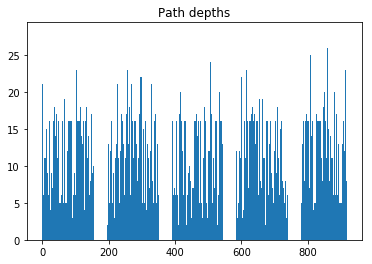

In [502]:
plt.bar(range(len(result)), depth)
plt.title('Path depths')
plt.show()

Percentage of links, that went through phylosophic articles

In [503]:
print(str(round(phyl_rate * 100/len(result), 2)) + '%')

39.98%


Number of initial articles that didn't make crawler STOP VS articles that went through phylosophic ones:

In [504]:
print(len(result), 'vs', phyl_rate)

918 vs 367


## 2. Books lib (0.5 баллов)
Напишите сайт-библиотеку для книг. Он должен удовлетворять следующему функционалу:
* Иметь одну главную страницу со списком авторов и ниже их произведений.
* Можно кликнуть на автора и получить список его произведений на отдельной стр.
* Можно кликнуть на книгу и получить текст книги на отдельной стр.
* Оформление и улучшение функционала приветствуются. Но можно обойтись заголовками и ссылками.

<b>Особенности реализации</b>:
* Список книг и авторов заранее не задан и должен быть создан автоматически. (<i>как - понятно из следующего описания</i>)
* Все книги хранятся по каталогам, которые имеют имя автора.
* Каждая книга имеет название, которое и будет показано в ссылке.
* Архив с книгами в папке с заданием (books.zip).
* Плюсом будет, если вы "замайните" книги, вместо использования готового архива (+0.2 балла).
* Использовать flask и bootstrap стили.

<b>PS</b> Лучше выполнять не в ipython notebook, а прислать отчет в pdf и код.